# Session 2: Classical Decomposition and Smoothing

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Decompose time series into trend, seasonal, and irregular components
2. Apply classical decomposition methods (additive and multiplicative)
3. Implement various smoothing techniques (moving averages, exponential smoothing)
4. Use the Hodrick-Prescott (HP) filter for trend extraction
5. Understand the STL decomposition method
6. Apply these techniques to financial and economic data

### Prerequisites
- Session 1: Introduction to Time Series Analysis
- Basic understanding of stationarity and autocorrelation

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.interpolate import interp1d
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Time Series Components

### 1.1 Decomposition Framework

A time series $y_t$ can be decomposed into several components:

1. **Trend ($T_t$)**: Long-term movement or direction in the data
2. **Seasonal ($S_t$)**: Regular, predictable patterns that repeat over fixed periods
3. **Cyclical ($C_t$)**: Longer-term fluctuations around the trend (not necessarily fixed period)
4. **Irregular/Random ($I_t$)**: Unpredictable, random variations (residual component)

### 1.2 Types of Decomposition

**Additive Model**:
$$y_t = T_t + S_t + C_t + I_t$$

**Assumptions**:
- Seasonal fluctuations are roughly constant over time
- Appropriate when seasonal variation is independent of the level

**Multiplicative Model**:
$$y_t = T_t \times S_t \times C_t \times I_t$$

**Assumptions**:
- Seasonal fluctuations increase/decrease proportionally with trend level
- Often used for economic and business data

**Log transformation**: Can convert multiplicative to additive:
$$\log(y_t) = \log(T_t) + \log(S_t) + \log(C_t) + \log(I_t)$$

### 1.3 When to Use Each Model

- **Additive**: When seasonal variations are stable in absolute terms
- **Multiplicative**: When seasonal variations increase with the level of the series
- **Visual inspection**: Plot the data to see if seasonal amplitude changes with level

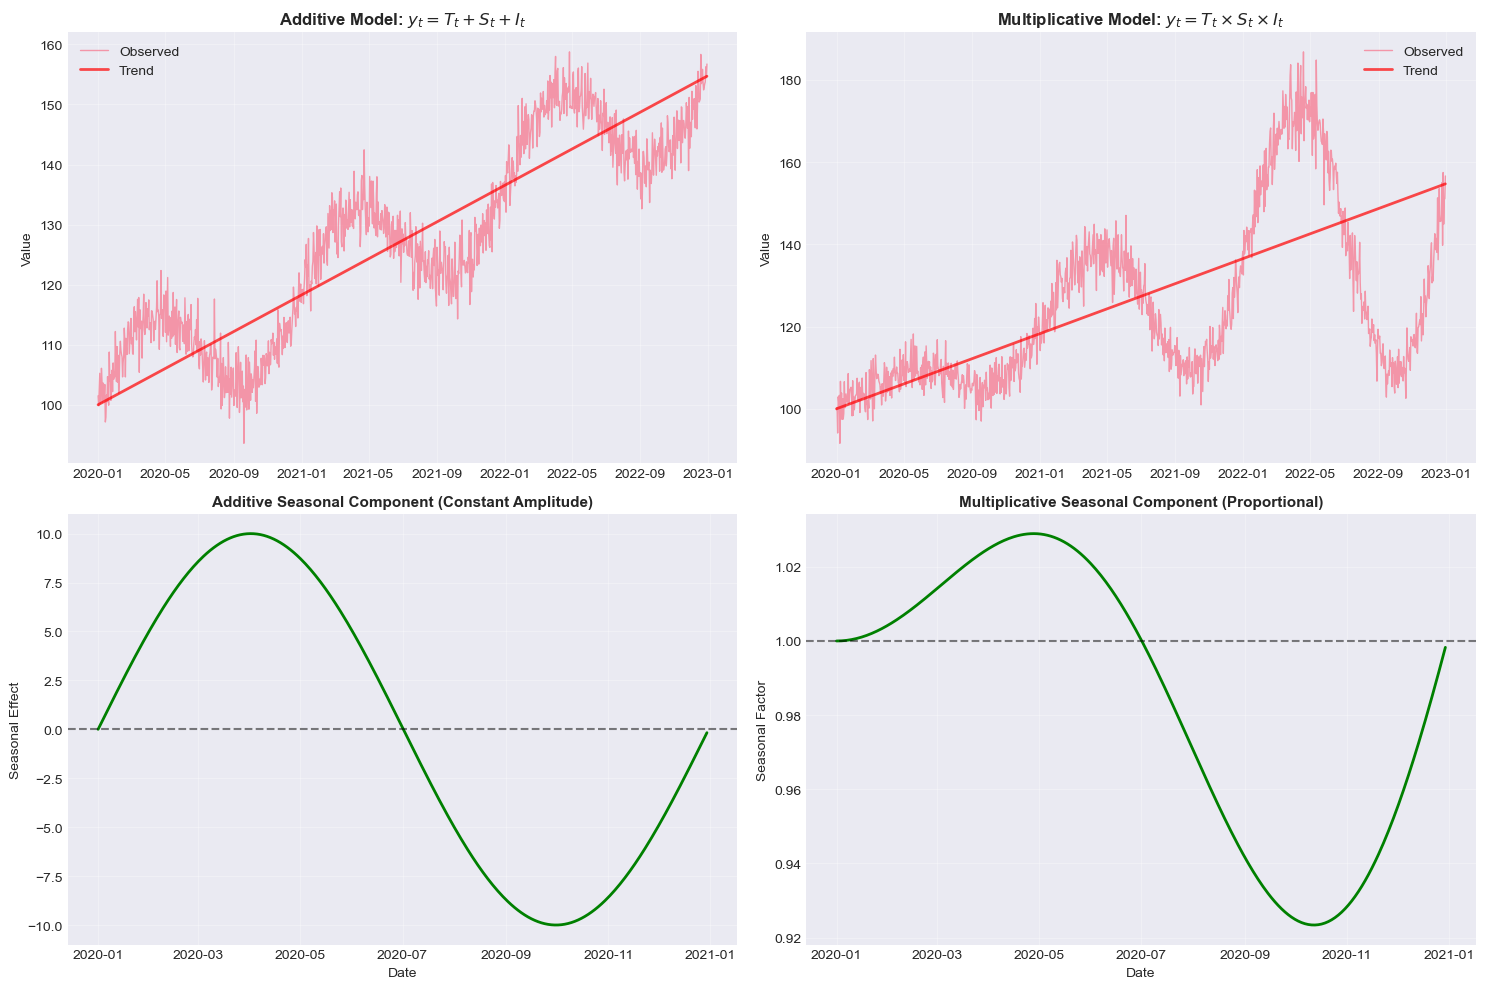

Key Observations:
• Additive: Seasonal variations remain constant regardless of trend level
• Multiplicative: Seasonal variations increase as the trend increases
• Multiplicative model is common in economic data (GDP, sales, etc.)


In [34]:
# Generate synthetic data with different decomposition types
np.random.seed(42)
T = 365 * 3  # 3 years of daily data
t = np.arange(T)

# Trend component
trend = 100 + 0.05 * t

# Seasonal component (yearly pattern)
seasonal = 10 * np.sin(2 * np.pi * t / 365)

# Irregular component
irregular = np.random.normal(0, 3, T)

# Additive series
y_additive = trend + seasonal + irregular

# Multiplicative series
seasonal_mult = 1 + 0.1 * np.sin(2 * np.pi * t / 365) * t/365
irregular_mult = 1 + np.random.normal(0, 0.03, T)
y_multiplicative = trend * seasonal_mult * irregular_mult

# Create date index
dates = pd.date_range(start='2020-01-01', periods=T, freq='D')

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Additive series
axes[0, 0].plot(dates, y_additive, linewidth=1, alpha=0.7, label='Observed')
axes[0, 0].plot(dates, trend, linewidth=2, color='red', label='Trend', alpha=0.7)
axes[0, 0].set_title('Additive Model: $y_t = T_t + S_t + I_t$', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Multiplicative series
axes[0, 1].plot(dates, y_multiplicative, linewidth=1, alpha=0.7, label='Observed')
axes[0, 1].plot(dates, trend, linewidth=2, color='red', label='Trend', alpha=0.7)
axes[0, 1].set_title('Multiplicative Model: $y_t = T_t \\times S_t \\times I_t$', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Seasonal components
axes[1, 0].plot(dates[:365], seasonal[:365], linewidth=2, color='green')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Additive Seasonal Component (Constant Amplitude)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Seasonal Effect')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(dates[:365], seasonal_mult[:365], linewidth=2, color='green')
axes[1, 1].axhline(y=1, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Multiplicative Seasonal Component (Proportional)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Seasonal Factor')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• Additive: Seasonal variations remain constant regardless of trend level")
print("• Multiplicative: Seasonal variations increase as the trend increases")
print("• Multiplicative model is common in economic data (GDP, sales, etc.)")

## 2. Classical Decomposition Methods

### 2.1 Classical Decomposition Algorithm

**For Additive Model**:

1. **Estimate Trend** ($\hat{T}_t$): Use moving average of order $m$ (where $m$ = seasonal period)
   $$\hat{T}_t = \frac{1}{m}\sum_{j=-k}^{k} y_{t+j}$$
   
2. **Detrend**: $d_t = y_t - \hat{T}_t$

3. **Estimate Seasonal** ($\hat{S}_t$): Average detrended values for each season
   $$\hat{S}_i = \frac{1}{n}\sum_{j} d_{t_{ij}}$$
   where $t_{ij}$ are all time points in season $i$

4. **Normalize**: Ensure $\sum_{i=1}^{m} \hat{S}_i = 0$

5. **Estimate Irregular**: $\hat{I}_t = y_t - \hat{T}_t - \hat{S}_t$

**For Multiplicative Model**:

Similar steps, but using division instead of subtraction:
- Detrend: $d_t = y_t / \hat{T}_t$
- Final irregular: $\hat{I}_t = y_t / (\hat{T}_t \times \hat{S}_t)$

### 2.2 Limitations

1. Loses observations at the beginning and end (due to moving average)
2. Assumes seasonal component is constant over time
3. Cannot handle missing values well
4. Trend-cycle component is not separated

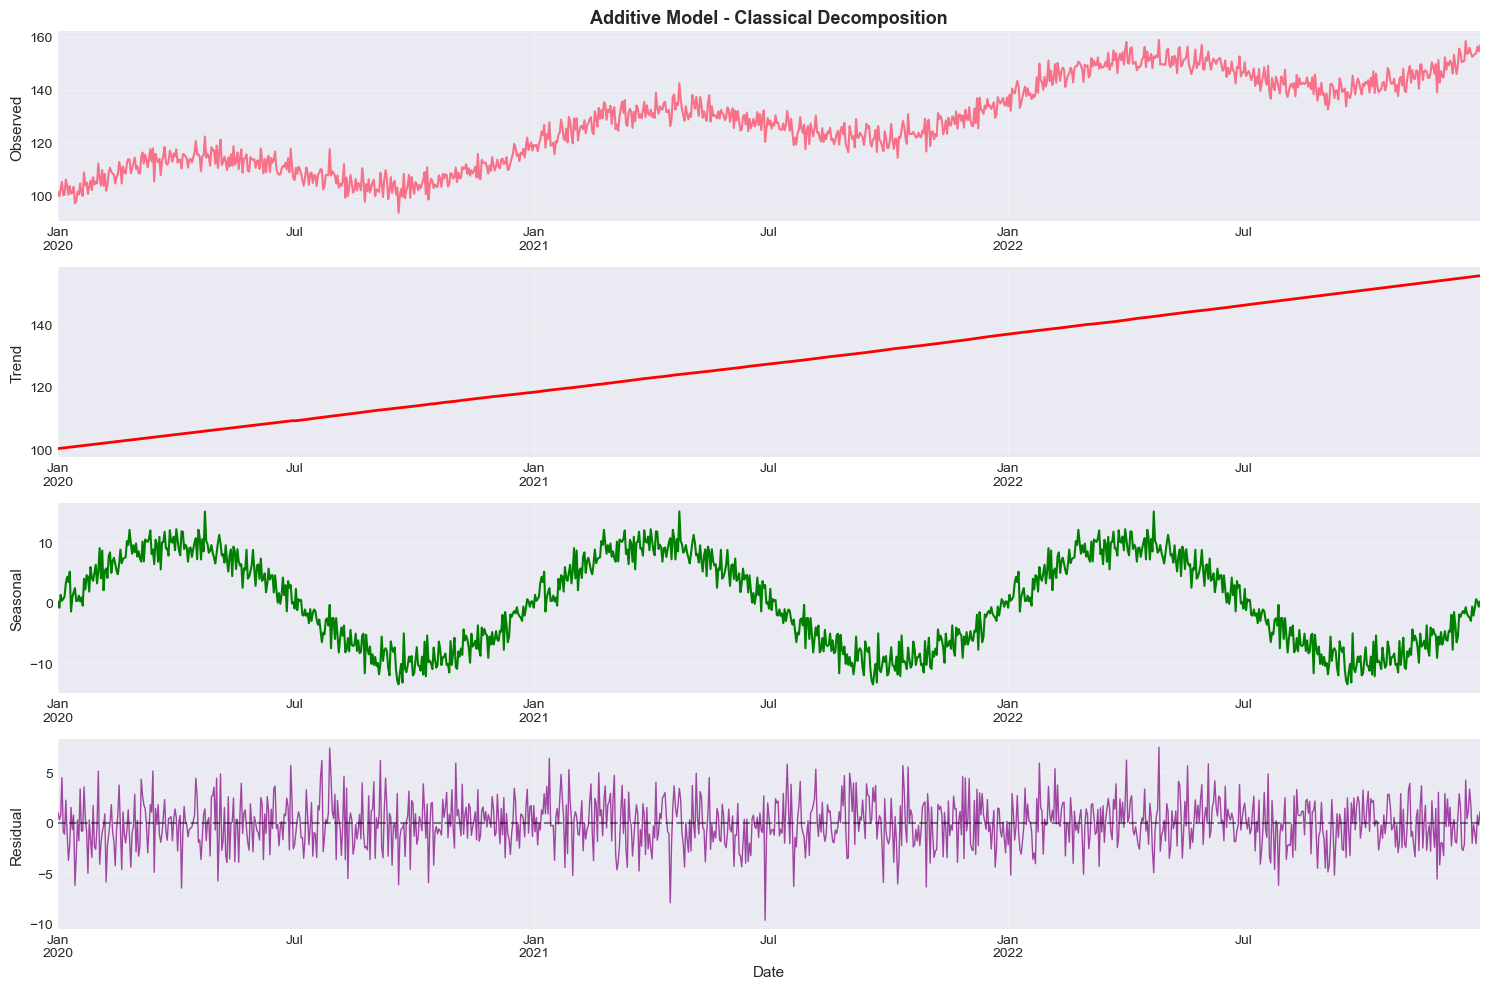

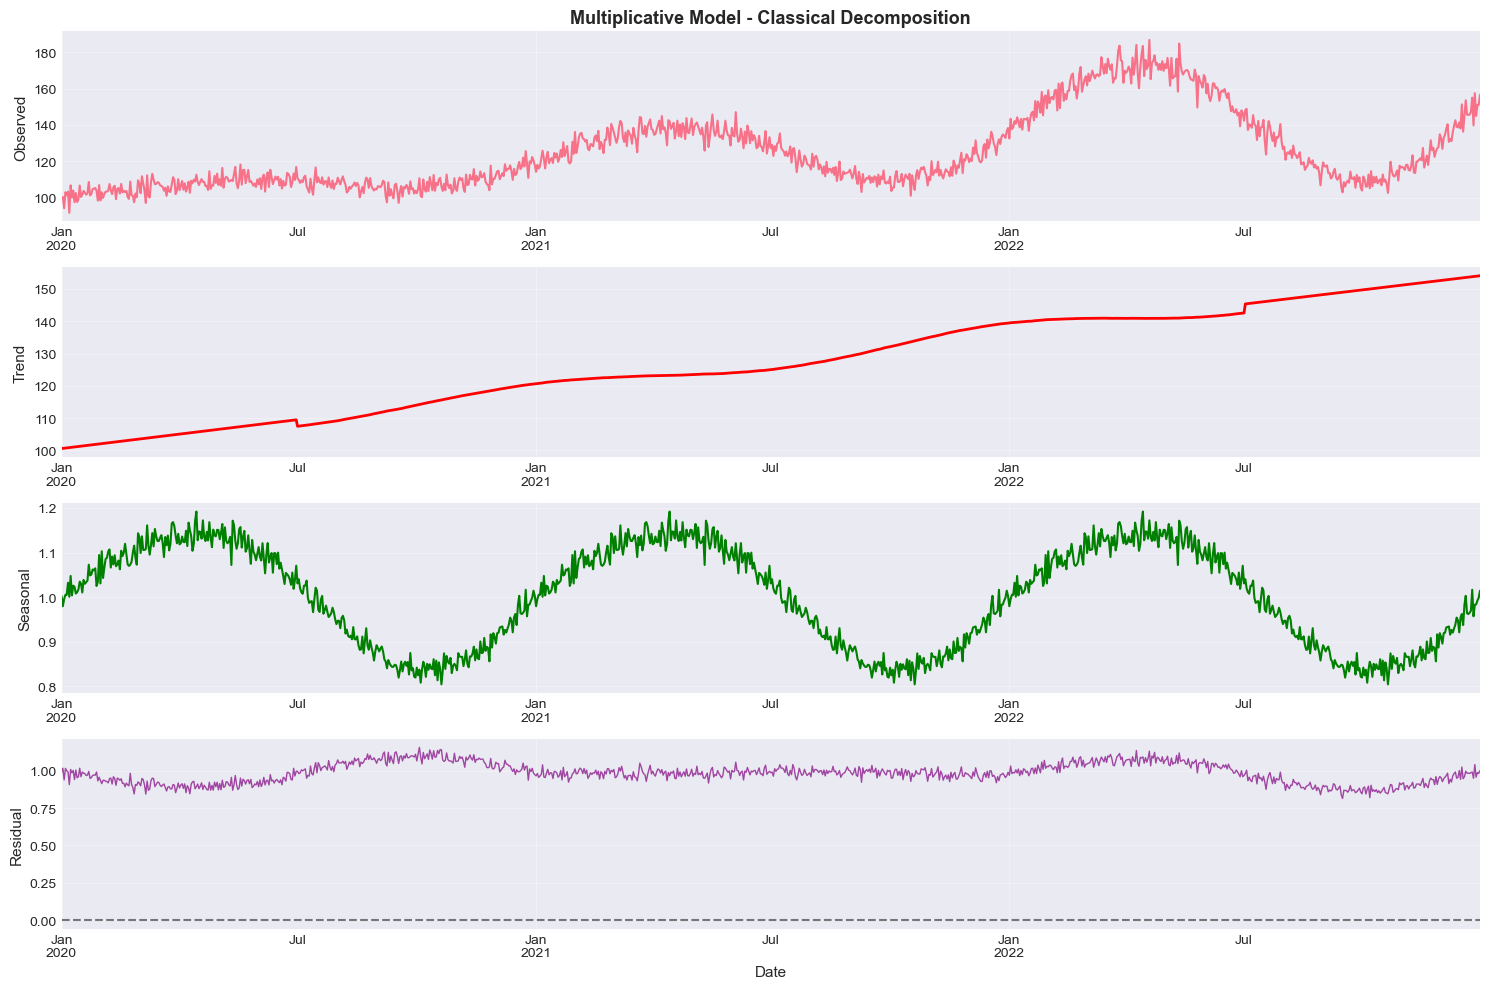

In [36]:
# Apply classical decomposition
def apply_classical_decomposition(data, model='additive', period=None):
    """
    Apply classical seasonal decomposition.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data
    model : str
        'additive' or 'multiplicative'
    period : int
        Seasonal period (if None, will be inferred)
    
    Returns:
    --------
    result : DecomposeResult
        Decomposition result object
    """
    result = seasonal_decompose(data, model=model, period=period, extrapolate_trend='freq')
    return result

def plot_decomposition(result, title=''):
    """
    Plot decomposition results.
    """
    fig, axes = plt.subplots(4, 1, figsize=(15, 10))
    
    # Original
    result.observed.plot(ax=axes[0], linewidth=1.5)
    axes[0].set_ylabel('Observed', fontsize=11)
    axes[0].set_title(f'{title} - Classical Decomposition', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    result.trend.plot(ax=axes[1], linewidth=2, color='red')
    axes[1].set_ylabel('Trend', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    result.seasonal.plot(ax=axes[2], linewidth=1.5, color='green')
    axes[2].set_ylabel('Seasonal', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    result.resid.plot(ax=axes[3], linewidth=1, color='purple', alpha=0.7)
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[3].set_ylabel('Residual', fontsize=11)
    axes[3].set_xlabel('Date', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Apply to synthetic additive data
ts_additive = pd.Series(y_additive, index=dates, name='Additive Series')
decomp_add = apply_classical_decomposition(ts_additive, model='additive', period=365)
plot_decomposition(decomp_add, title='Additive Model')

# Apply to synthetic multiplicative data
ts_mult = pd.Series(y_multiplicative, index=dates, name='Multiplicative Series')
decomp_mult = apply_classical_decomposition(ts_mult, model='multiplicative', period=365)
plot_decomposition(decomp_mult, title='Multiplicative Model')

In [37]:
# Calculate statistics on residuals
def analyze_residuals(result, name=''):
    """
    Analyze decomposition residuals.
    """
    resid = result.resid.dropna()
    
    print(f"\n{'='*60}")
    print(f"Residual Analysis: {name}")
    print(f"{'='*60}")
    print(f"Mean: {resid.mean():.4f}")
    print(f"Std Dev: {resid.std():.4f}")
    print(f"Min: {resid.min():.4f}")
    print(f"Max: {resid.max():.4f}")
    print(f"Skewness: {resid.skew():.4f}")
    print(f"Kurtosis: {resid.kurtosis():.4f}")
    
    # Calculate variance explained
    var_original = result.observed.var()
    var_residual = resid.var()
    var_explained = (1 - var_residual / var_original) * 100
    print(f"\nVariance Explained: {var_explained:.2f}%")
    
    return resid

resid_add = analyze_residuals(decomp_add, 'Additive Model')
resid_mult = analyze_residuals(decomp_mult, 'Multiplicative Model')


Residual Analysis: Additive Model
Mean: -0.0747
Std Dev: 2.3557
Min: -9.6646
Max: 7.4672
Skewness: -0.0170
Kurtosis: 0.2368

Variance Explained: 97.82%

Residual Analysis: Multiplicative Model
Mean: 0.9842
Std Dev: 0.0649
Min: 0.8145
Max: 1.1565
Skewness: 0.0097
Kurtosis: -0.5099

Variance Explained: 100.00%


## 3. Moving Averages

### 3.1 Simple Moving Average (SMA)

The simple moving average of order $k$ is:

$$\text{SMA}_t(k) = \frac{1}{k}\sum_{i=0}^{k-1} y_{t-i}$$

**Properties**:
- Smooths short-term fluctuations
- Highlights longer-term trends
- All observations have equal weight
- Lags the actual data (larger $k$ = more lag)

### 3.2 Centered Moving Average (CMA)

For odd $k = 2m + 1$:
$$\text{CMA}_t(k) = \frac{1}{k}\sum_{i=-m}^{m} y_{t+i}$$

For even $k$: Use weighted average at endpoints

**Advantage**: No lag, but loses observations at both ends

### 3.3 Weighted Moving Average (WMA)

$$\text{WMA}_t = \sum_{i=0}^{k-1} w_i y_{t-i}, \quad \sum_{i=0}^{k-1} w_i = 1$$

**Common choices**:
- Linear weights: $w_i = \frac{k-i}{k(k+1)/2}$
- Exponential weights: See exponential smoothing section

In [44]:
def calculate_moving_averages(data, windows=[5, 10, 20, 50]):
    """
    Calculate simple moving averages with different windows.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data
    windows : list
        List of window sizes
    
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with original data and MAs
    """
    df = pd.DataFrame(data)
    
    for w in windows:
        df[f'SMA_{w}'] = data.rolling(window=w, center=False).mean()
        df[f'CMA_{w}'] = data.rolling(window=w, center=True).mean()
    
    return df

def calculate_weighted_ma(data, window=10):
    """
    Calculate linearly weighted moving average.
    """
    weights = np.arange(1, window + 1)
    weights = weights / weights.sum()
    
    wma = data.rolling(window=window).apply(
        lambda x: np.sum(weights * x), raw=True
    )
    
    return wma

# Download real data for demonstration
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2022-01-01', end='2024-01-01', progress=False)['Close']
sp500 = sp500.dropna()

# Calculate moving averages
windows = [5, 20, 50, 200]
ma_data = calculate_moving_averages(sp500, windows)

# Calculate weighted MA
ma_data['WMA_20'] = calculate_weighted_ma(sp500, window=20)

print(f"\nData period: {sp500.index[0].date()} to {sp500.index[-1].date()}")
print(f"Number of observations: {len(sp500)}")


Data period: 2022-01-03 to 2023-12-29
Number of observations: 501


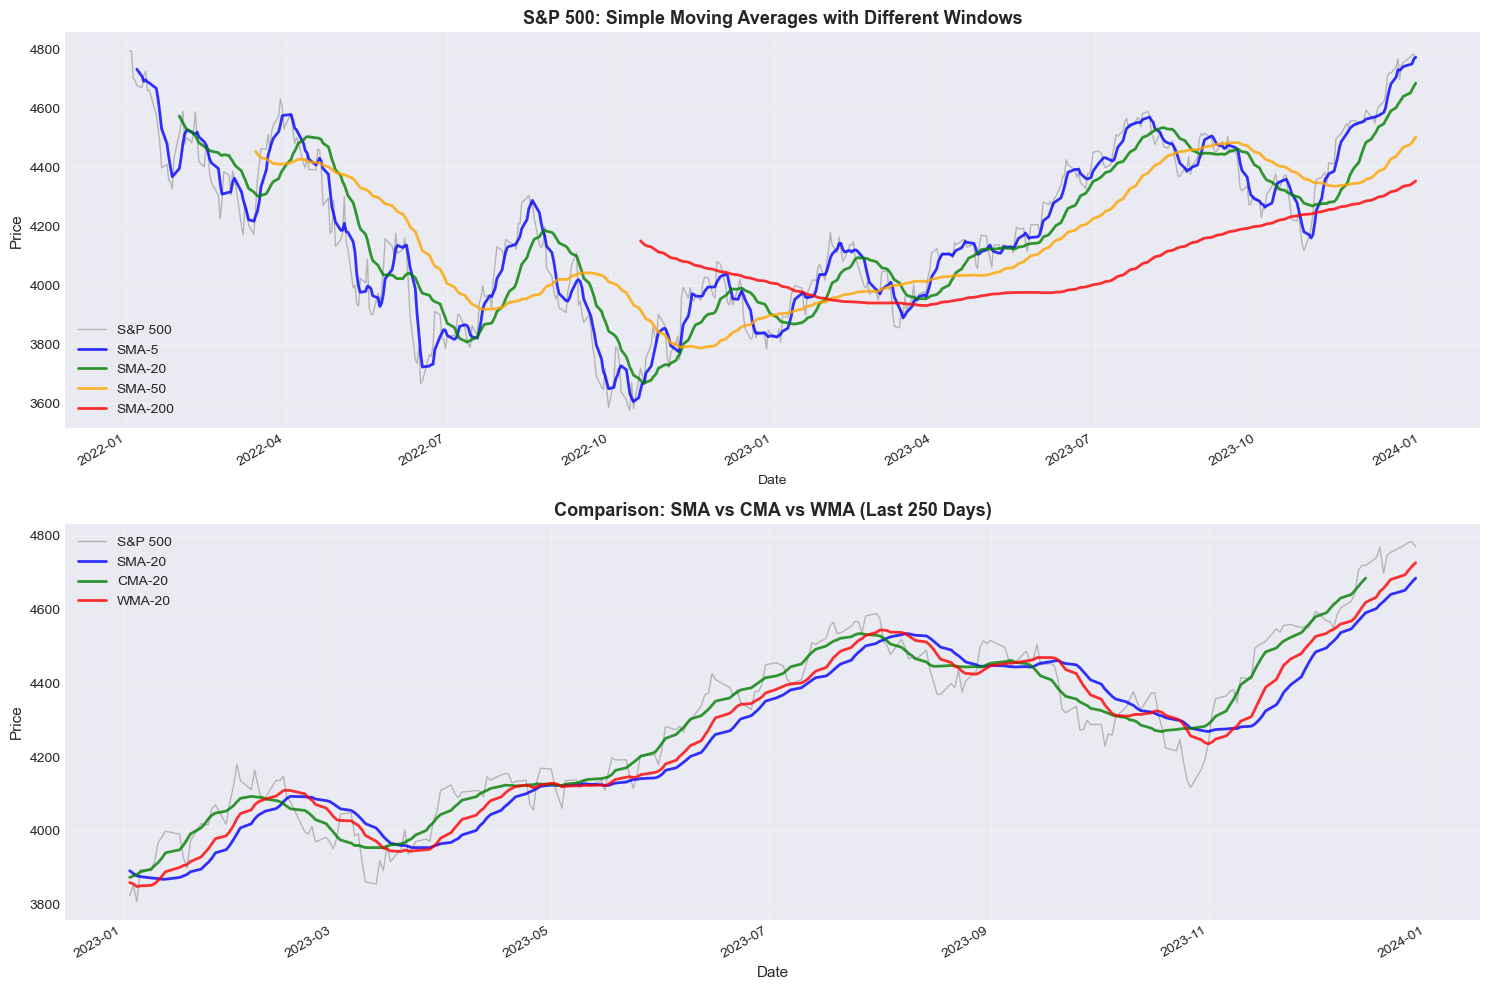


Key Observations:
• Larger windows create smoother trends but with more lag
• CMA-20 has no lag but loses data at boundaries
• WMA-20 gives more weight to recent observations
• Crossovers between short and long MAs are used as trading signals


In [52]:
# Plot moving averages
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Different window sizes
ma_data['^GSPC'].plot(ax=axes[0], linewidth=1, alpha=0.5, label='S&P 500', color='gray')
colors = ['blue', 'green', 'orange', 'red']
for window, color in zip(windows, colors):
    ma_data[f'SMA_{window}'].plot(ax=axes[0], linewidth=2, label=f'SMA-{window}', color=color, alpha=0.8)

axes[0].set_title('S&P 500: Simple Moving Averages with Different Windows', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparison of MA types
recent_data = ma_data.iloc[-250:]  # Last year
recent_data['^GSPC'].plot(ax=axes[1], linewidth=1, alpha=0.5, label='S&P 500', color='gray')
recent_data['SMA_20'].plot(ax=axes[1], linewidth=2, label='SMA-20', color='blue', alpha=0.8)
recent_data['CMA_20'].plot(ax=axes[1], linewidth=2, label='CMA-20', color='green', alpha=0.8)
recent_data['WMA_20'].plot(ax=axes[1], linewidth=2, label='WMA-20', color='red', alpha=0.8)

axes[1].set_title('Comparison: SMA vs CMA vs WMA (Last 250 Days)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Price', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Larger windows create smoother trends but with more lag")
print("• CMA-20 has no lag but loses data at boundaries")
print("• WMA-20 gives more weight to recent observations")
print("• Crossovers between short and long MAs are used as trading signals")

## 4. Exponential Smoothing

### 4.1 Simple Exponential Smoothing (SES)

**Recursive form**:
$$\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha)\hat{y}_{t|t-1}$$

**Expanded form**:
$$\hat{y}_{t+1|t} = \alpha \sum_{i=0}^{t-1} (1-\alpha)^i y_{t-i} + (1-\alpha)^t \hat{y}_{1|0}$$

where $0 < \alpha < 1$ is the smoothing parameter.

**Properties**:
- Weights decline exponentially as observations get older
- Larger $\alpha$ = more weight on recent observations
- Equivalent to ARIMA(0,1,1) model

### 4.2 Double Exponential Smoothing (Holt's Method)

Extends SES to handle trends:

**Level equation**: $\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

**Trend equation**: $b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

**Forecast**: $\hat{y}_{t+h|t} = \ell_t + h b_t$

where $\beta$ is the trend smoothing parameter.

### 4.3 Triple Exponential Smoothing (Holt-Winters)

Adds seasonal component:

**Additive Seasonality**:
- Level: $\ell_t = \alpha(y_t - s_{t-m}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$
- Season: $s_t = \gamma(y_t - \ell_t) + (1-\gamma)s_{t-m}$
- Forecast: $\hat{y}_{t+h|t} = \ell_t + h b_t + s_{t+h-m}$

**Multiplicative Seasonality**: Similar, but using multiplication/division

In [55]:
def apply_exponential_smoothing(data, method='simple', seasonal_periods=None, 
                                 seasonal='add', trend='add', alpha=None):
    """
    Apply exponential smoothing methods.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data
    method : str
        'simple', 'double', or 'triple'
    seasonal_periods : int
        Length of seasonal cycle (for triple ES)
    seasonal : str
        'add' or 'mul' (for triple ES)
    trend : str
        'add' or 'mul' (for double/triple ES)
    alpha : float
        Smoothing parameter (if None, will be optimized)
    
    Returns:
    --------
    model : fitted model object
    """
    if method == 'simple':
        model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=(alpha is None))
    elif method == 'double':
        model = ExponentialSmoothing(data, trend=trend).fit()
    elif method == 'triple':
        model = ExponentialSmoothing(
            data, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        ).fit()
    else:
        raise ValueError("Method must be 'simple', 'double', or 'triple'")
    
    return model

# Apply different exponential smoothing methods to S&P 500
print("Fitting Exponential Smoothing Models...\n")

# Simple ES with different alpha values
alphas = [0.1, 0.3, 0.6, 0.9]
ses_models = {}
for alpha in alphas:
    ses_models[alpha] = apply_exponential_smoothing(sp500, method='simple', alpha=alpha)

# Optimized simple ES
ses_opt = apply_exponential_smoothing(sp500, method='simple')
print(f"Optimized SES α: {ses_opt.params['smoothing_level']:.4f}")

# Double ES (Holt's method)
des = apply_exponential_smoothing(sp500, method='double', trend='add')
print(f"\nDouble ES parameters:")
print(f"  α (level): {des.params['smoothing_level']:.4f}")
print(f"  β (trend): {des.params['smoothing_trend']:.4f}")

Fitting Exponential Smoothing Models...

Optimized SES α: 1.0000

Double ES parameters:
  α (level): 0.9950
  β (trend): 0.0237


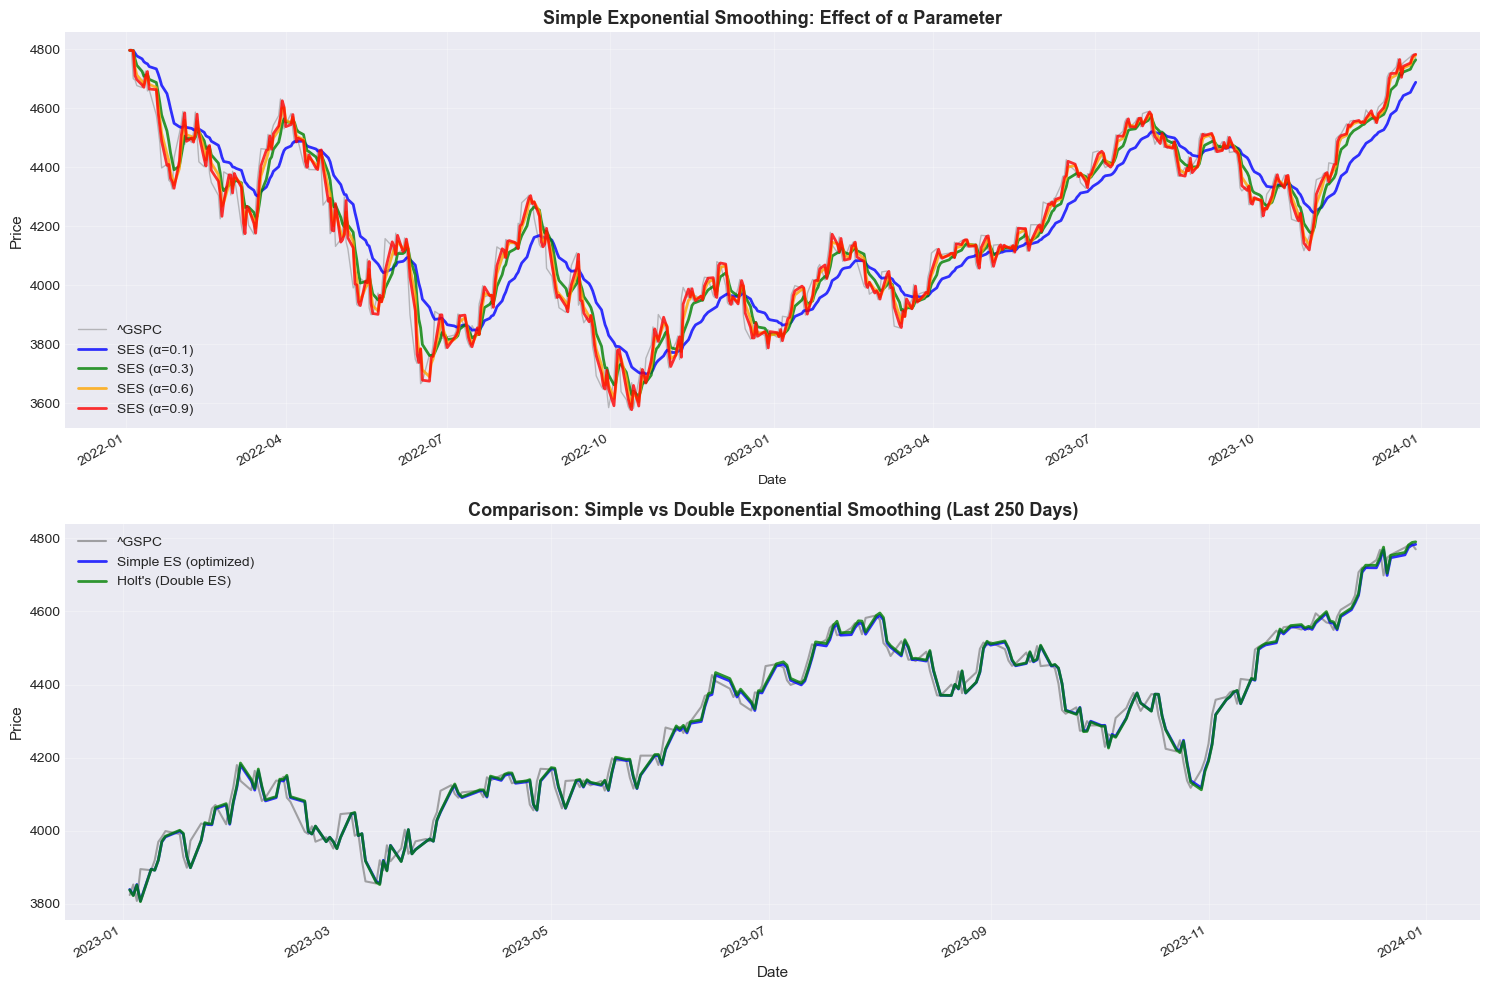


Key Observations:
• Low α (0.1): Heavy smoothing, slow to adapt to changes
• High α (0.9): Light smoothing, quick to adapt but more volatile
• Double ES captures trend better than simple ES
• Optimization finds best α to minimize forecast errors


In [57]:
# Plot exponential smoothing results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Simple ES with different alphas
sp500.plot(ax=axes[0], linewidth=1, alpha=0.5, label='Original', color='gray')
colors = ['blue', 'green', 'orange', 'red']
for alpha, color in zip(alphas, colors):
    ses_models[alpha].fittedvalues.plot(
        ax=axes[0], linewidth=2, label=f'SES (α={alpha})', color=color, alpha=0.8
    )

axes[0].set_title('Simple Exponential Smoothing: Effect of α Parameter', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparison of methods
recent = sp500.iloc[-250:]
recent.plot(ax=axes[1], linewidth=1.5, alpha=0.7, label='Original', color='gray')
ses_opt.fittedvalues.iloc[-250:].plot(
    ax=axes[1], linewidth=2, label='Simple ES (optimized)', color='blue', alpha=0.8
)
des.fittedvalues.iloc[-250:].plot(
    ax=axes[1], linewidth=2, label="Holt's (Double ES)", color='green', alpha=0.8
)

axes[1].set_title('Comparison: Simple vs Double Exponential Smoothing (Last 250 Days)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Price', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Low α (0.1): Heavy smoothing, slow to adapt to changes")
print("• High α (0.9): Light smoothing, quick to adapt but more volatile")
print("• Double ES captures trend better than simple ES")
print("• Optimization finds best α to minimize forecast errors")

In [124]:
# Calculate forecast errors
def calculate_errors(actual, fitted):
    """
    Calculate forecast error metrics.
    """
    errors = actual - fitted
    mae = np.abs(errors).mean()
    mse = (errors ** 2).mean()
    rmse = np.sqrt(mse)
    mape = (np.abs(errors / actual) * 100).mean()
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

print("\n" + "="*60)
print("Forecast Error Comparison")
print("="*60)

methods = {
    'SES (α=0.1)': ses_models[0.1].fittedvalues,
    'SES (α=0.6)': ses_models[0.6].fittedvalues,
    'SES (optimized)': ses_opt.fittedvalues,
    'Double ES': des.fittedvalues
}

results = []
for name, fitted in methods.items():
    aligned = sp500.align(fitted, join='inner', axis=0)
    errors = calculate_errors(aligned[0]['^GSPC'], aligned[1])
    errors['Method'] = name
    results.append(errors)

results_df = pd.DataFrame(results)
results_df = results_df[['Method', 'MAE', 'RMSE', 'MAPE']]
print("\n", results_df.to_string(index=False))

print("\n• Lower values indicate better fit")
print("• MAE: Mean Absolute Error")
print("• RMSE: Root Mean Squared Error")
print("• MAPE: Mean Absolute Percentage Error")


Forecast Error Comparison

          Method     MAE     RMSE   MAPE
    SES (α=0.1) 89.8914 109.7433 2.1653
    SES (α=0.6) 43.6035  54.7213 1.0554
SES (optimized) 38.0089  50.1268 0.9209
      Double ES 38.1065  50.4714 0.9229

• Lower values indicate better fit
• MAE: Mean Absolute Error
• RMSE: Root Mean Squared Error
• MAPE: Mean Absolute Percentage Error


## 5. Hodrick-Prescott (HP) Filter

### 5.1 HP Filter Methodology

The HP filter separates a time series $y_t$ into trend ($\tau_t$) and cyclical ($c_t$) components by minimizing:

$$\min_{\{\tau_t\}} \left\{ \sum_{t=1}^T (y_t - \tau_t)^2 + \lambda \sum_{t=2}^{T-1} [(\tau_{t+1} - \tau_t) - (\tau_t - \tau_{t-1})]^2 \right\}$$

**Components**:
- First term: Minimizes deviation from data (fit)
- Second term: Penalizes variability in trend (smoothness)
- $\lambda$: Smoothing parameter (controls tradeoff)

### 5.2 Choosing λ (Lambda)

**Standard values**:
- **Annual data**: $\lambda = 100$
- **Quarterly data**: $\lambda = 1,600$ (Hodrick-Prescott recommendation)
- **Monthly data**: $\lambda = 14,400$
- **Daily data**: $\lambda = 129,600$ (approximate)

**Rule of thumb**: $\lambda = 1600 \times \left(\frac{f_{new}}{f_{quarter}}\right)^4$

where $f$ is the frequency per year.

### 5.3 Properties and Criticisms

**Advantages**:
- Simple and intuitive
- No need to specify parametric form for trend
- Widely used in macroeconomics

**Disadvantages**:
- End-point problem (trend unreliable at boundaries)
- Can induce spurious cycles (Hamilton, 2018)
- Choice of $\lambda$ is somewhat arbitrary
- Not optimal for forecasting

In [127]:
def apply_hp_filter(data, lamb=1600):
    """
    Apply Hodrick-Prescott filter.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data
    lamb : float
        Smoothing parameter
    
    Returns:
    --------
    cycle : pd.Series
        Cyclical component
    trend : pd.Series
        Trend component
    """
    cycle, trend = hpfilter(data, lamb=lamb)
    return cycle, trend

# Download economic data (GDP)
print("Downloading economic data...")
# Using unemployment rate as proxy for economic data
import pandas_datareader as pdr
try:
    # Try to get US GDP data
    gdp = pdr.get_data_fred('GDP', start='2000-01-01', end='2024-01-01')
    gdp = gdp.dropna()
    gdp_log = np.log(gdp['GDP'])
    use_gdp = True
except:
    print("Could not download GDP data, using generated data instead...")
    # Generate realistic GDP-like data
    T = 96  # 24 years quarterly
    t = np.arange(T)
    trend = 9.5 + 0.015 * t
    cycle = 0.02 * np.sin(2 * np.pi * t / 32) + 0.01 * np.sin(2 * np.pi * t / 12)
    noise = np.random.normal(0, 0.005, T)
    gdp_log = pd.Series(
        trend + cycle + noise,
        index=pd.date_range(start='2000-01-01', periods=T, freq='Q'),
        name='Log GDP'
    )
    use_gdp = False

print(f"Data period: {gdp_log.index[0]} to {gdp_log.index[-1]}")
print(f"Number of observations: {len(gdp_log)}")

Data period: 2000-01-01 00:00:00 to 2024-01-01 00:00:00
Number of observations: 97


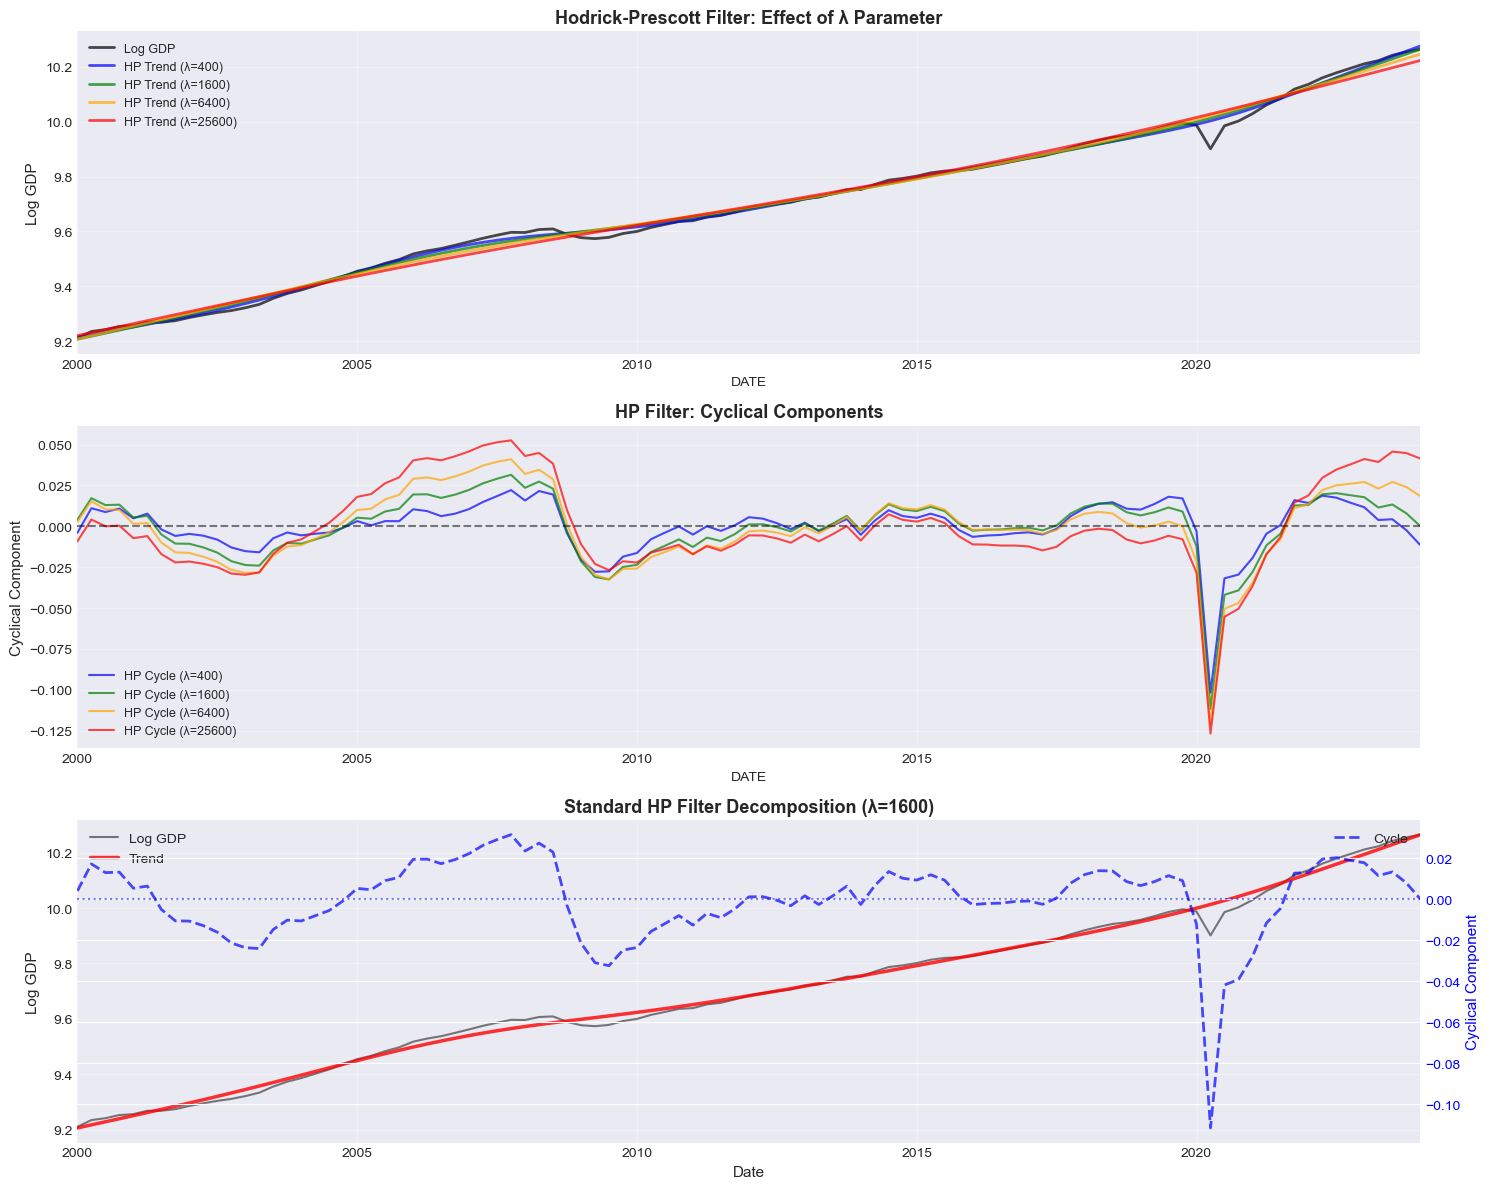


Key Observations:
• Smaller λ: More flexible trend, captures more short-term movements
• Larger λ: Smoother trend, attributes more to cyclical component
• λ=1600 is standard for quarterly macroeconomic data
• Cyclical component shows business cycle fluctuations


In [129]:
# Apply HP filter with different lambda values
lambdas = [400, 1600, 6400, 25600]
hp_results = {}

for lamb in lambdas:
    cycle, trend = apply_hp_filter(gdp_log, lamb=lamb)
    hp_results[lamb] = {'cycle': cycle, 'trend': trend}

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Original data with different trends
gdp_log.plot(ax=axes[0], linewidth=2, label='Log GDP', color='black', alpha=0.7)
colors = ['blue', 'green', 'orange', 'red']
for lamb, color in zip(lambdas, colors):
    hp_results[lamb]['trend'].plot(
        ax=axes[0], linewidth=2, label=f'HP Trend (λ={lamb})', color=color, alpha=0.7
    )

axes[0].set_title('Hodrick-Prescott Filter: Effect of λ Parameter', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Log GDP', fontsize=11)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Cyclical components
for lamb, color in zip(lambdas, colors):
    hp_results[lamb]['cycle'].plot(
        ax=axes[1], linewidth=1.5, label=f'HP Cycle (λ={lamb})', color=color, alpha=0.7
    )
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('HP Filter: Cyclical Components', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Cyclical Component', fontsize=11)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: Standard HP filter (λ=1600) decomposition
gdp_log.plot(ax=axes[2], linewidth=1.5, label='Log GDP', color='black', alpha=0.5)
hp_results[1600]['trend'].plot(
    ax=axes[2], linewidth=2.5, label='Trend', color='red', alpha=0.8
)
# Plot cycle on secondary axis
ax2 = axes[2].twinx()
hp_results[1600]['cycle'].plot(
    ax=ax2, linewidth=2, label='Cycle', color='blue', alpha=0.7, style='--'
)
ax2.axhline(y=0, color='blue', linestyle=':', alpha=0.5)
ax2.set_ylabel('Cyclical Component', fontsize=11, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

axes[2].set_title('Standard HP Filter Decomposition (λ=1600)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Log GDP', fontsize=11)
axes[2].legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Smaller λ: More flexible trend, captures more short-term movements")
print("• Larger λ: Smoother trend, attributes more to cyclical component")
print("• λ=1600 is standard for quarterly macroeconomic data")
print("• Cyclical component shows business cycle fluctuations")

In [131]:
# Analyze cyclical properties
cycle_1600 = hp_results[1600]['cycle']

print("\n" + "="*60)
print("HP Filter Cyclical Component Analysis (λ=1600)")
print("="*60)
print(f"Mean: {cycle_1600.mean():.6f}")
print(f"Std Dev: {cycle_1600.std():.6f}")
print(f"Min: {cycle_1600.min():.6f}")
print(f"Max: {cycle_1600.max():.6f}")

# Calculate turning points
cycle_diff = cycle_1600.diff()
peaks = cycle_1600[(cycle_diff.shift(1) > 0) & (cycle_diff < 0)]
troughs = cycle_1600[(cycle_diff.shift(1) < 0) & (cycle_diff > 0)]

print(f"\nNumber of peaks: {len(peaks)}")
print(f"Number of troughs: {len(troughs)}")

if len(peaks) > 0:
    print("\nPeak dates:")
    for date in peaks.index:
        print(f"  {date.strftime('%Y-%m')}")

if len(troughs) > 0:
    print("\nTrough dates:")
    for date in troughs.index:
        print(f"  {date.strftime('%Y-%m')}")


HP Filter Cyclical Component Analysis (λ=1600)
Mean: -0.000000
Std Dev: 0.019163
Min: -0.111670
Max: 0.031495

Number of peaks: 20
Number of troughs: 19

Peak dates:
  2000-07
  2001-01
  2001-07
  2004-01
  2005-04
  2006-07
  2008-01
  2008-07
  2011-01
  2011-07
  2012-07
  2013-04
  2014-01
  2014-10
  2015-07
  2017-04
  2018-07
  2019-10
  2022-10
  2023-10

Trough dates:
  2000-10
  2001-04
  2003-07
  2004-04
  2005-07
  2006-10
  2008-04
  2009-10
  2011-04
  2011-10
  2013-01
  2013-07
  2014-04
  2015-04
  2016-04
  2017-07
  2019-04
  2020-07
  2023-07


## 6. STL Decomposition

### 6.1 STL (Seasonal and Trend decomposition using Loess)

**STL** is a versatile and robust method for decomposing time series developed by Cleveland et al. (1990).

**Key Features**:
1. Handles any type of seasonality (not just monthly or quarterly)
2. Seasonal component allowed to change over time
3. Robustness to outliers
4. User can control smoothness of trend and seasonal components

**Algorithm** (simplified):
1. Detrend the series
2. Extract seasonal component using loess
3. Remove seasonal component and smooth to get trend
4. Iterate until convergence

**Parameters**:
- `seasonal`: Length of seasonal smoother (must be odd)
- `trend`: Length of trend smoother
- `seasonal_deg`: Degree of polynomial for seasonal smoothing
- `trend_deg`: Degree of polynomial for trend smoothing
- `robust`: Whether to use robust weights to handle outliers

### 6.2 Advantages over Classical Decomposition

1. No loss of observations at endpoints
2. Time-varying seasonal pattern
3. Handles outliers better
4. More flexible seasonal patterns
5. Provides seasonal and trend smoothness control

In [133]:
# Download monthly economic data for STL
print("Downloading monthly retail sales data...")
try:
    # US Retail Sales
    retail = pdr.get_data_fred('RSXFS', start='2010-01-01', end='2024-01-01')
    retail = retail.dropna()
    retail = retail['RSXFS']
    use_retail = True
except:
    print("Could not download retail data, using generated data instead...")
    # Generate realistic retail-like data
    T = 168  # 14 years monthly
    t = np.arange(T)
    trend = 300000 + 1000 * t
    seasonal = 20000 * np.sin(2 * np.pi * t / 12) + 15000 * np.sin(4 * np.pi * t / 12)
    noise = np.random.normal(0, 5000, T)
    retail = pd.Series(
        trend + seasonal + noise,
        index=pd.date_range(start='2010-01-01', periods=T, freq='MS'),
        name='Retail Sales'
    )
    use_retail = False

print(f"Data period: {retail.index[0].date()} to {retail.index[-1].date()}")
print(f"Number of observations: {len(retail)}")

# Apply STL decomposition
stl = STL(retail, seasonal=13, trend=None, robust=True)
stl_result = stl.fit()

# Also apply classical decomposition for comparison
classical = seasonal_decompose(retail, model='additive', period=12, extrapolate_trend='freq')

Data period: 2010-01-01 to 2024-01-01
Number of observations: 169


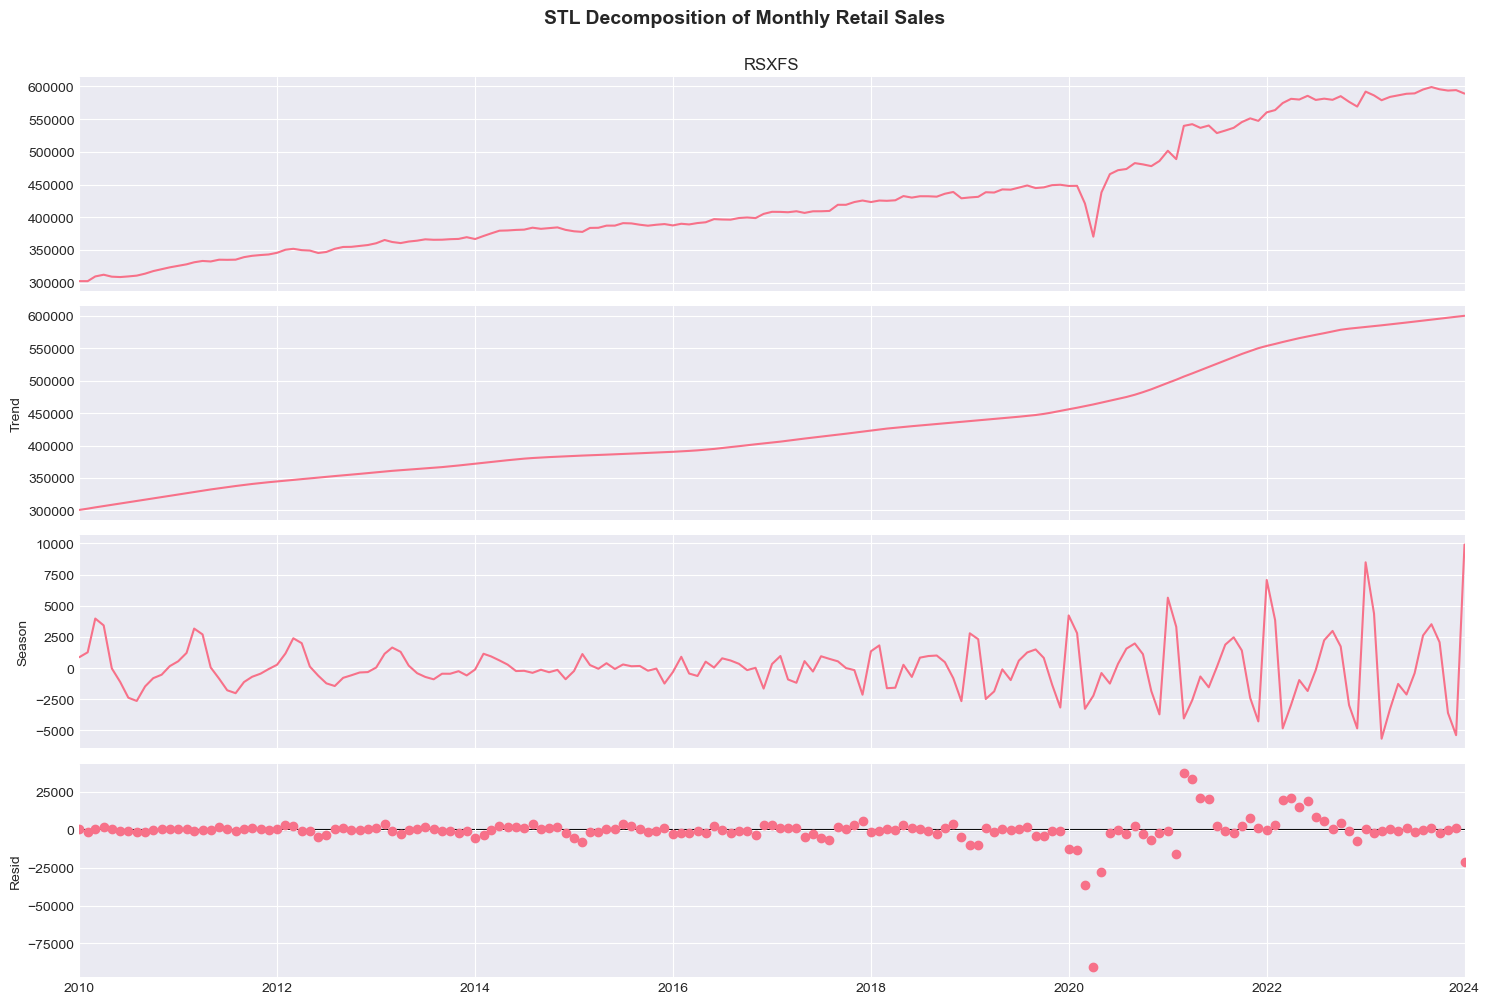

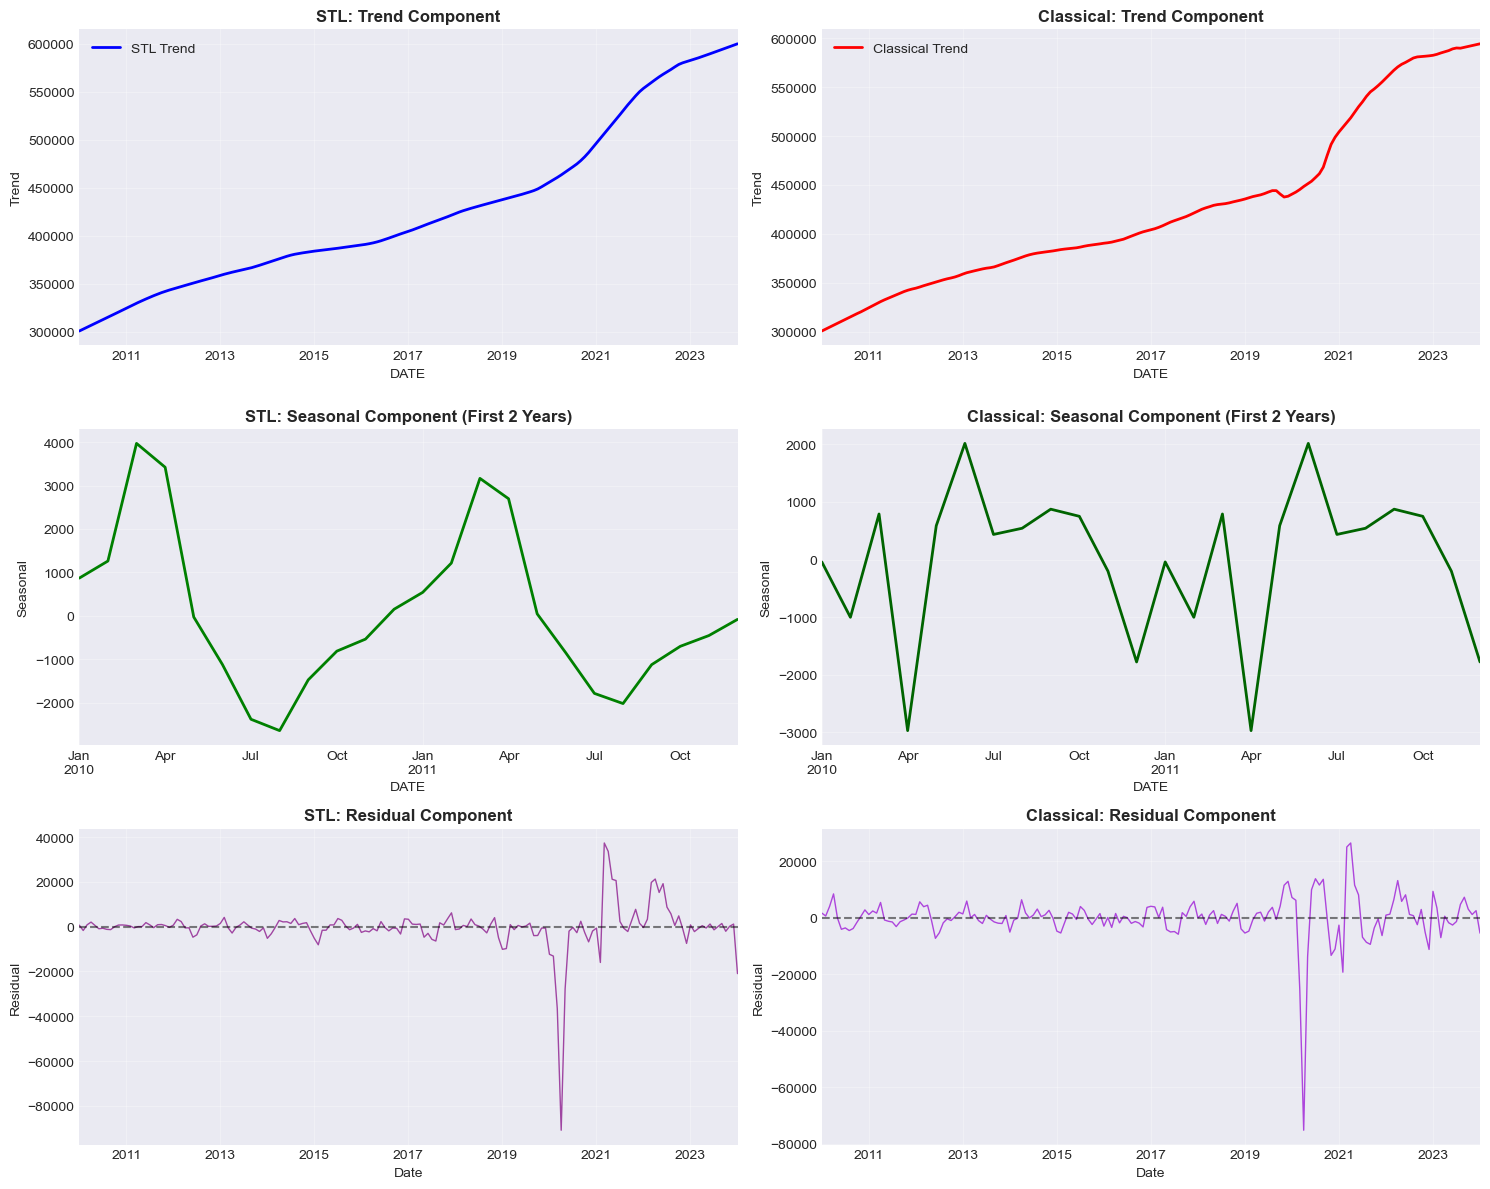


Key Differences:
• STL: Smoother trend, no data loss at endpoints
• STL: Seasonal pattern can vary over time
• Classical: Fixed seasonal pattern repeats exactly
• STL: Better handling of outliers with robust=True


In [135]:
# Plot STL decomposition
fig = stl_result.plot()
fig.set_size_inches(15, 10)
fig.suptitle('STL Decomposition of Monthly Retail Sales', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Compare STL and Classical decomposition
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Row 1: Trend comparison
stl_result.trend.plot(ax=axes[0, 0], linewidth=2, color='blue', label='STL Trend')
axes[0, 0].set_title('STL: Trend Component', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Trend')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

classical.trend.plot(ax=axes[0, 1], linewidth=2, color='red', label='Classical Trend')
axes[0, 1].set_title('Classical: Trend Component', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Trend')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Seasonal comparison (show 2 years)
stl_result.seasonal.iloc[:24].plot(ax=axes[1, 0], linewidth=2, color='green')
axes[1, 0].set_title('STL: Seasonal Component (First 2 Years)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Seasonal')
axes[1, 0].grid(True, alpha=0.3)

classical.seasonal.iloc[:24].plot(ax=axes[1, 1], linewidth=2, color='darkgreen')
axes[1, 1].set_title('Classical: Seasonal Component (First 2 Years)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Seasonal')
axes[1, 1].grid(True, alpha=0.3)

# Row 3: Residual comparison
stl_result.resid.plot(ax=axes[2, 0], linewidth=1, color='purple', alpha=0.7)
axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 0].set_title('STL: Residual Component', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Residual')
axes[2, 0].set_xlabel('Date')
axes[2, 0].grid(True, alpha=0.3)

classical.resid.plot(ax=axes[2, 1], linewidth=1, color='darkviolet', alpha=0.7)
axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Classical: Residual Component', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Residual')
axes[2, 1].set_xlabel('Date')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Differences:")
print("• STL: Smoother trend, no data loss at endpoints")
print("• STL: Seasonal pattern can vary over time")
print("• Classical: Fixed seasonal pattern repeats exactly")
print("• STL: Better handling of outliers with robust=True")

In [137]:
# Compare residual statistics
print("\n" + "="*60)
print("Residual Analysis: STL vs Classical Decomposition")
print("="*60)

resid_stl = stl_result.resid.dropna()
resid_classical = classical.resid.dropna()

stats_data = {
    'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis'],
    'STL': [
        resid_stl.mean(),
        resid_stl.std(),
        resid_stl.min(),
        resid_stl.max(),
        resid_stl.skew(),
        resid_stl.kurtosis()
    ],
    'Classical': [
        resid_classical.mean(),
        resid_classical.std(),
        resid_classical.min(),
        resid_classical.max(),
        resid_classical.skew(),
        resid_classical.kurtosis()
    ]
}

stats_df = pd.DataFrame(stats_data)
print("\n", stats_df.to_string(index=False))

# Calculate variance explained
var_original = retail.var()
var_resid_stl = resid_stl.var()
var_resid_classical = resid_classical.var()

var_explained_stl = (1 - var_resid_stl / var_original) * 100
var_explained_classical = (1 - var_resid_classical / var_original) * 100

print(f"\nVariance Explained:")
print(f"  STL: {var_explained_stl:.2f}%")
print(f"  Classical: {var_explained_classical:.2f}%")


Residual Analysis: STL vs Classical Decomposition

   Metric         STL   Classical
    Mean   -354.9745    102.1443
 Std Dev  10182.3098   8364.3920
     Min -90867.0982 -75139.6514
     Max  37336.4536  26524.0153
Skewness     -3.9137     -4.1912
Kurtosis     39.4553     39.5939

Variance Explained:
  STL: 98.57%
  Classical: 99.04%


## 7. Practical Application: Bitcoin Price Decomposition

Let's apply these techniques to Bitcoin price data to extract trend and cyclical components.

In [141]:
# Download Bitcoin data
print("Downloading Bitcoin price data...")
btc = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', progress=False)['Close']
btc = btc.dropna()
btc_log = np.log(btc)

print(f"Data period: {btc.index[0].date()} to {btc.index[-1].date()}")
print(f"Number of observations: {len(btc)}")

# Apply different smoothing methods
print("\nApplying smoothing methods...")

# 1. Moving averages
btc_ma30 = btc.rolling(window=30, center=False).mean()
btc_ma90 = btc.rolling(window=90, center=False).mean()

# 2. Exponential smoothing
btc_es = ExponentialSmoothing(btc, trend='add').fit()

# 3. HP filter (for log prices)
btc_hp_cycle, btc_hp_trend = hpfilter(btc_log, lamb=129600)  # Daily data
btc_hp_trend = np.exp(btc_hp_trend)  # Convert back to levels

print("Done!")

Data period: 2018-01-01 to 2023-12-31
Number of observations: 2191

Applying smoothing methods...
Done!


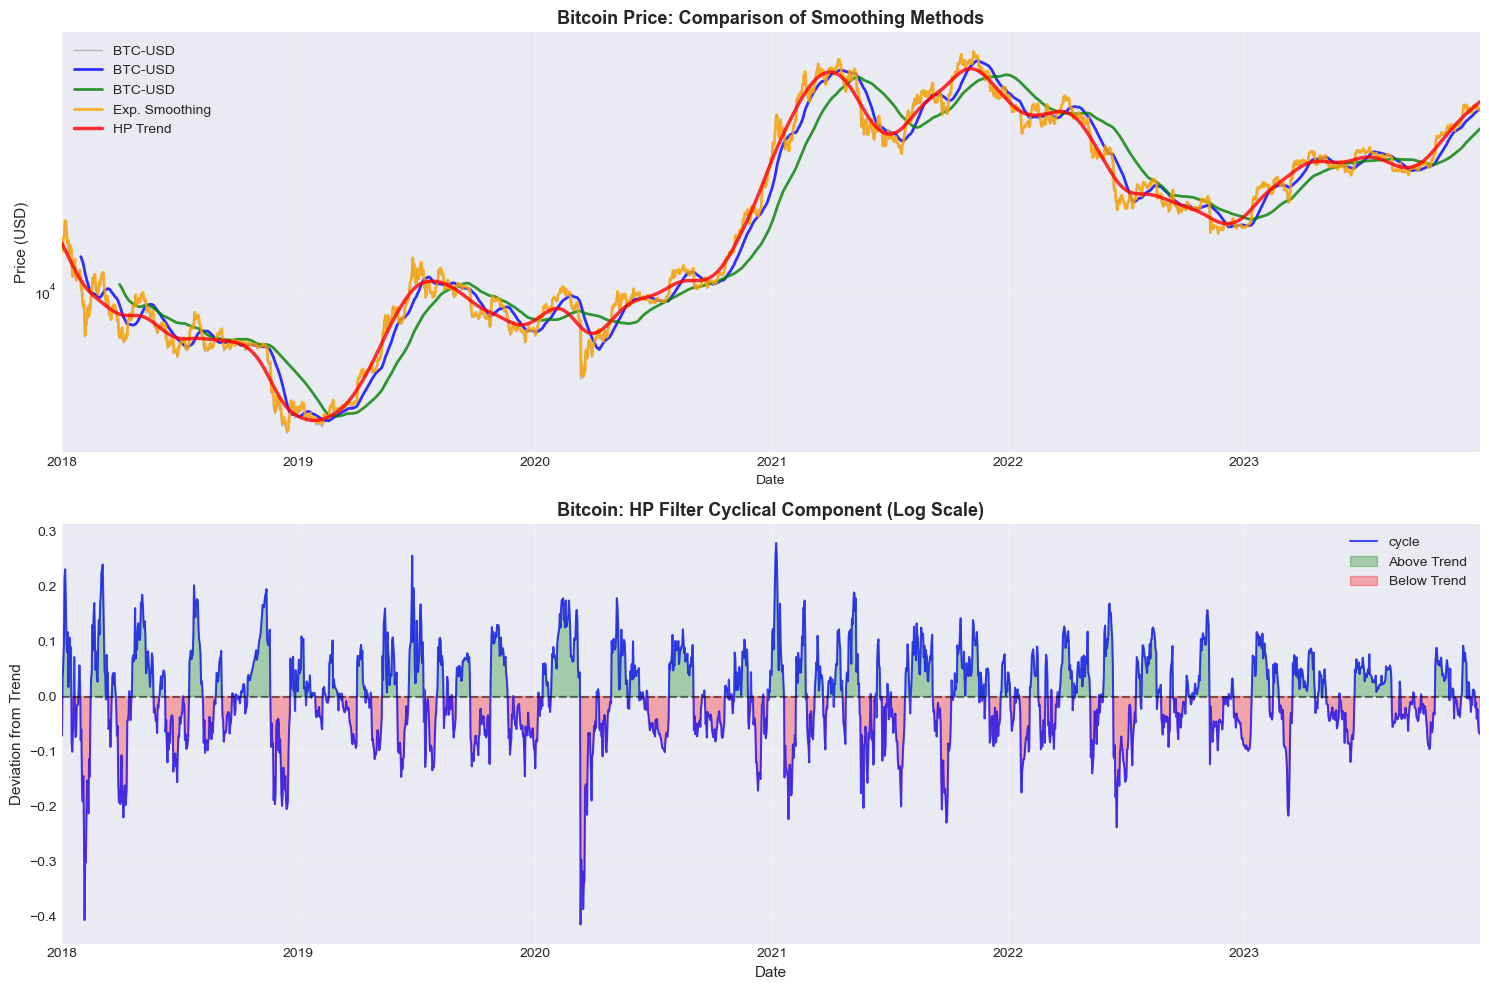


Interpretation:
• MA-30 and MA-90 show medium-term price movements
• Exponential smoothing adapts to recent trends
• HP trend extracts the long-term growth path
• Cyclical component shows periods of overvaluation/undervaluation
• Green areas: Bitcoin trading above trend (potential bubble)
• Red areas: Bitcoin trading below trend (potential buying opportunity)


In [143]:
# Plot comparison of methods
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Price with different trends
btc.plot(ax=axes[0], linewidth=1, alpha=0.5, label='BTC Price', color='gray')
btc_ma30.plot(ax=axes[0], linewidth=2, label='MA-30', color='blue', alpha=0.8)
btc_ma90.plot(ax=axes[0], linewidth=2, label='MA-90', color='green', alpha=0.8)
btc_es.fittedvalues.plot(ax=axes[0], linewidth=2, label='Exp. Smoothing', color='orange', alpha=0.8)
btc_hp_trend.plot(ax=axes[0], linewidth=2.5, label='HP Trend', color='red', alpha=0.8)

axes[0].set_title('Bitcoin Price: Comparison of Smoothing Methods', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: HP Filter cyclical component
btc_hp_cycle.plot(ax=axes[1], linewidth=1.5, color='blue', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(btc_hp_cycle.index, 0, btc_hp_cycle, 
                      where=(btc_hp_cycle > 0), color='green', alpha=0.3, label='Above Trend')
axes[1].fill_between(btc_hp_cycle.index, 0, btc_hp_cycle, 
                      where=(btc_hp_cycle <= 0), color='red', alpha=0.3, label='Below Trend')

axes[1].set_title('Bitcoin: HP Filter Cyclical Component (Log Scale)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Deviation from Trend', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• MA-30 and MA-90 show medium-term price movements")
print("• Exponential smoothing adapts to recent trends")
print("• HP trend extracts the long-term growth path")
print("• Cyclical component shows periods of overvaluation/undervaluation")
print("• Green areas: Bitcoin trading above trend (potential bubble)")
print("• Red areas: Bitcoin trading below trend (potential buying opportunity)")

In [145]:
# Analyze cyclical patterns
print("\n" + "="*60)
print("Bitcoin Cyclical Analysis")
print("="*60)

# Calculate statistics
print(f"\nCyclical Component Statistics:")
print(f"Mean: {btc_hp_cycle.mean():.4f}")
print(f"Std Dev: {btc_hp_cycle.std():.4f}")
print(f"Min: {btc_hp_cycle.min():.4f} (Most undervalued)")
print(f"Max: {btc_hp_cycle.max():.4f} (Most overvalued)")

# Find extreme deviations
threshold = 0.2  # 20% deviation
overvalued = btc_hp_cycle[btc_hp_cycle > threshold]
undervalued = btc_hp_cycle[btc_hp_cycle < -threshold]

print(f"\nPeriods of Significant Deviation (|deviation| > {threshold}):")
print(f"Days above trend by >{threshold}: {len(overvalued)} ({len(overvalued)/len(btc_hp_cycle)*100:.1f}%)")
print(f"Days below trend by >{threshold}: {len(undervalued)} ({len(undervalued)/len(btc_hp_cycle)*100:.1f}%)")

if len(overvalued) > 0:
    print(f"\nMost overvalued periods:")
    top_overvalued = btc_hp_cycle.nlargest(5)
    for date, val in top_overvalued.items():
        print(f"  {date.date()}: +{val:.2%} above trend")

if len(undervalued) > 0:
    print(f"\nMost undervalued periods:")
    top_undervalued = btc_hp_cycle.nsmallest(5)
    for date, val in top_undervalued.items():
        print(f"  {date.date()}: {val:.2%} below trend")


Bitcoin Cyclical Analysis

Cyclical Component Statistics:
Mean: -0.0000
Std Dev: 0.0820
Min: -0.4153 (Most undervalued)
Max: 0.2801 (Most overvalued)

Periods of Significant Deviation (|deviation| > 0.2):
Days above trend by >0.2: 11 (0.5%)
Days below trend by >0.2: 26 (1.2%)

Most overvalued periods:
  2021-01-08: +28.01% above trend
  2019-06-26: +25.69% above trend
  2021-01-07: +25.67% above trend
  2021-01-09: +25.46% above trend
  2018-03-05: +24.06% above trend

Most undervalued periods:
  2020-03-12: -41.53% below trend
  2018-02-05: -40.72% below trend
  2020-03-16: -38.72% below trend
  2020-03-14: -36.00% below trend
  2020-03-17: -34.17% below trend


## 8. Summary and Best Practices

### 8.1 Method Selection Guide

| Method | Best Used For | Advantages | Limitations |
|--------|--------------|------------|-------------|
| **Moving Averages** | Quick trend identification | Simple, interpretable | Lag, arbitrary window choice |
| **Exponential Smoothing** | Short-term forecasting | Adaptive, minimal lag | Assumes specific model structure |
| **Classical Decomposition** | Teaching/understanding | Clear components | Fixed seasonality, data loss |
| **HP Filter** | Business cycle analysis | Smooth trend, widely used | End-point problem, spurious cycles |
| **STL** | Complex seasonal patterns | Flexible, robust | Computationally intensive |

### 8.2 Key Takeaways

1. **Decomposition Purpose**
   - Understand data structure before modeling
   - Extract economically meaningful components
   - Remove seasonality for better analysis

2. **Model Choice**
   - Additive: Stable seasonal amplitude
   - Multiplicative: Seasonal amplitude proportional to level
   - Test both and compare residuals

3. **Smoothing Parameters**
   - Larger window/λ → smoother, more lag
   - Smaller window/λ → responsive, more noise
   - Consider data frequency when choosing parameters

4. **Validation**
   - Check residuals for white noise
   - Compare variance explained
   - Visual inspection is crucial

5. **Financial Applications**
   - Trend following strategies
   - Mean reversion identification
   - Cycle analysis for market timing

### 8.3 Next Session Preview

In **Session 3**, we will cover:
- Error-Trend-Seasonal (ETS) framework
- State space models for exponential smoothing
- Model selection and information criteria
- Forecasting with prediction intervals
- ETS for financial time series

## 9. Exercises

### Exercise 1: Decomposition Comparison
Choose a different cryptocurrency or stock and:
1. Apply classical decomposition (both additive and multiplicative)
2. Apply STL decomposition
3. Compare the residuals and discuss which model fits better
4. What does the seasonal component reveal (if any)?

### Exercise 2: HP Filter Sensitivity
Using GDP or another macroeconomic variable:
1. Apply HP filter with λ = [100, 400, 1600, 6400]
2. Calculate the percentage of time the cycle is positive vs negative
3. Compare cycle volatility across different λ values
4. Which λ provides the most economically interpretable business cycle?

### Exercise 3: Trading Strategy
Develop a simple trading strategy based on smoothing:
1. Calculate 50-day and 200-day moving averages for a stock
2. Generate buy signals when MA-50 crosses above MA-200
3. Generate sell signals when MA-50 crosses below MA-200
4. Backtest the strategy and calculate returns

### Exercise 4: Seasonal Adjustment
Download monthly unemployment rate data:
1. Apply STL decomposition
2. Calculate seasonally adjusted series (trend + residual)
3. Compare original vs seasonally adjusted series
4. Which provides better insight into economic conditions?

### Exercise 5: Custom Smoothing
Implement your own exponential smoothing function:
1. Write a function that takes data and α as inputs
2. Compare your results with statsmodels SimpleExpSmoothing
3. Experiment with different α values
4. Calculate forecast errors for different α

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Textbooks:
1. Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). OTexts. Available at: https://otexts.com/fpp3/
2. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press.
3. Shumway, R.H., & Stoffer, D.S. (2017). *Time Series Analysis and Its Applications* (4th ed.). Springer.

### Papers:
1. Cleveland, R.B., Cleveland, W.S., McRae, J.E., & Terpenning, I. (1990). STL: A seasonal-trend decomposition procedure based on loess. *Journal of Official Statistics*, 6(1), 3-73.
2. Hodrick, R.J., & Prescott, E.C. (1997). Postwar US business cycles: An empirical investigation. *Journal of Money, Credit, and Banking*, 29(1), 1-16.
3. Hamilton, J.D. (2018). Why you should never use the Hodrick-Prescott filter. *Review of Economics and Statistics*, 100(5), 831-843.
4. Gardner Jr, E.S. (2006). Exponential smoothing: The state of the art—Part II. *International Journal of Forecasting*, 22(4), 637-666.

### Python Resources:
1. statsmodels documentation: https://www.statsmodels.org/stable/tsa.html
2. STL implementation: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]